# Titanic - Machine Learning from Disaster
## Predicting survivors of the Titanic shipwreck

<p align='center'>
    <img src='img/titanic.jpg'>
</p>

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we want to build a model that predicts which passengers survived the Titanic shipwreck, using data (ie name, age, gender, socio-economic class, etc).

To solve the problem, we will follow these step:

- **0.0.** Data Collection.
- **1.0.** Data description.
- **2.0.** Feature Engineering
- **3.0.** Filtering the features
- **4.0.** Exploratory Data Analysis
- **5.0.** Data preparation
- **6.0.** Feature selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter fine tuning
- **9.0.** Translation and interpretation of the error
- **10.0.** Deploy model to production

# 0.0 Imports

In [143]:
import pandas                as pd
import numpy                 as np
from scipy                   import stats

import matplotlib.pyplot     as plt
import matplotlib.gridspec   as gridspec
import seaborn               as sns
import scikitplot            as skplt

from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from IPython.display         import Image

## 0.1. Helper functions

in this step, we'll document all the functions that will be used to solve the problem.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( df ):
    
    d = {'Sex': [], 'Embarked': [], 'Formal_title': []} 
    
    for i in range( df.shape[1] ):
        
        for j in range( df.shape[1] ):
            
            v1 = df.iloc[:, i]
            v2 = df.iloc[:, j]
            cm = pd.crosstab( v1, v2 ).values
            chi2 = stats.chi2_contingency( cm )[0]
            n = cm.sum()
            r, k = cm.shape
            chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
            kcorr = k - (k-1)**2/(n-1)

            rcorr = r - (r-1)**2/(n-1)
    
            result = np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))
        
            d[df.columns[i]].append( result )
    
    return pd.DataFrame(d)

def ml_metrics( y_test, y_pred ):
    
    accuracy = accuracy_score( y_test, y_pred )
    precision = precision_score( y_test, y_pred )
    recall = recall_score( y_test, y_pred )
    f1 = f1_score( y_test, y_pred )
    
    return pd.DataFrame( {
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1': f1 }, 
      index = [0] )

def cross_validation( model, X_train, y_train ):
    
    accuracy = cross_val_score( model, X_train, y_train, cv=5, scoring='accuracy' )
    precision = cross_val_score( model, X_train, y_train, cv=5, scoring='precision' )
    recall = cross_val_score( model, X_train, y_train, cv=5, scoring='recall' )
    f1 = cross_val_score( model, X_train, y_train, cv=5, scoring='f1' )
    
    return pd.DataFrame( {
      'Accuracy CV': np.round( np.mean( accuracy ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( accuracy ), 2 ).astype( str ),
      'Precision CV': np.round( np.mean( precision ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( precision ), 2 ).astype( str ),
      'Recall CV': np.round( np.mean( recall ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( recall ), 2 ).astype( str ),
      'F1 CV': np.round( np.mean( f1 ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( f1 ), 2 ).astype( str ) }, 
      index = [0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

### Overview

Here we will import the data we will need to predict the survivors of the wreck.

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set will be used to build our machine learning models. Our model will be based on “characteristics” such as gender and class of passengers. We will also use feature engineering to create new features.

The test set will be used to see how well our model performs on unseen data. For each passenger in the test set, we'll use the model we've trained to predict whether or not they survived the sinking of the Titanic.

We also have gender_submission.csv, a set of predictions that assume all and only women survive, and we will use that as the baseline for our solution.

### Data Dictionary

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


### Data assumptions

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

We'll load **"train.csv"** and **"test.csv"** and unite them to build a dataframe that will call **"df_raw"**. 

In [4]:
train = pd.read_csv( 'datasets/titanic/train.csv' )
test = pd.read_csv( 'datasets/titanic/test.csv' )

df_raw = pd.concat( [train, test], axis=0 ).reset_index()
df_raw.drop( 'index', axis=1, inplace=True )

df_raw.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
265,266,0.0,2,"Reeves, Mr. David",male,36.0,0,0,C.A. 17248,10.5,NaN,S


# 1.0. Data Description

in this step we will perform the following tasks:

- Rename Columns
- Data Dimensions
- Data Types
- Check missing values
- Fillout missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 1.1. Rename Columns

In this first step we will rename the columns to be more understandable. We will use the snake case pattern.

In [7]:
df1.columns = ['Passenger_id', 'Survived', 'Ticket_class', 'Name', 'Sex', 'Age', 'Acc_siblings_or_spouses',
             'Acc_parents_or_children', 'Ticket', 'Fare', 'Cabin', 'Embarked']

## 1.2. Data Dimensions

Let's see the size of the dataset dimensions.

In [8]:
# Train dataset
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1309
Number of columns: 12


## 1.3. Data Types

In this step we want to see what the data types are. This is important for us to treat the data correctly, and change them if necessary.

In [9]:
df1.dtypes

Passenger_id                 int64
Survived                   float64
Ticket_class                 int64
Name                        object
Sex                         object
Age                        float64
Acc_siblings_or_spouses      int64
Acc_parents_or_children      int64
Ticket                      object
Fare                       float64
Cabin                       object
Embarked                    object
dtype: object

## 1.4. Check NA

In this step, we want to see if there are any missing values in the dataset. If so, we must solve this problem because our machine learning algorithms are not able to handle null values.

In [10]:
# Train dataset
df1.isna().sum().sort_values( ascending=False )

Cabin                      1014
Survived                    418
Age                         263
Embarked                      2
Fare                          1
Ticket                        0
Acc_parents_or_children       0
Acc_siblings_or_spouses       0
Sex                           0
Name                          0
Ticket_class                  0
Passenger_id                  0
dtype: int64

## 1.5. Fillout NA

As we saw in the previous step, there are four variables in the dataset that have missing values: Cabin, Survived, Age, Fare and Embarked.
We'll explain how to solve the problem in each variable.

- Survived
    - the missing values in this column are from the data that will be used to test the model, so they do not need to be filled.

- Cabin
    - This variable will probably not be useful for the predictive model and has a large number of missing values, so we will delete it.

- Age
    - For this variable we will use the mean or median.
    
- Fare
    - There is only one missing value in the test dataset, so in this case we will just fill with the mean.
    
- Embarked
    - There are only two missing values in the training dataset, so in this case let's just fill in the mode.

In [11]:
# Cabin 
df1.drop( 'Cabin', axis=1, inplace=True )

# Fare
df1['Fare'].fillna( float( format( np.mean( df1['Fare'] ), ".4f" )  ), inplace=True )

# Embarked
df1['Embarked'].fillna( df1['Embarked'].mode()[0], inplace=True )

Now, to fill in the missing values from the age column, we will first look at how the passengers' ages are distributed. As we can see, most passengers are in the 20 to 30 age range.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


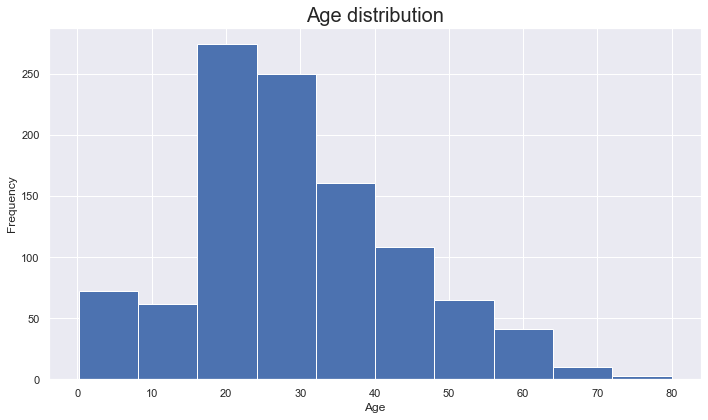

In [12]:
fig, ax = subplots( figsize=(10, 6) )

ax.hist( 'Age', data=df1 )
ax.set_title( 'Age distribution', fontsize=20 )
ax.set_xlabel( 'Age' )
ax.set_ylabel( 'Frequency' )

plt.tight_layout()

We will use a measure of centrality to fill in the missing values. However, we will first plot a boxplot to see if there are any outliers in the dataset. As we can see, both the training and testing datasets have outliers, so we will use the median as it is less affected by outliers.

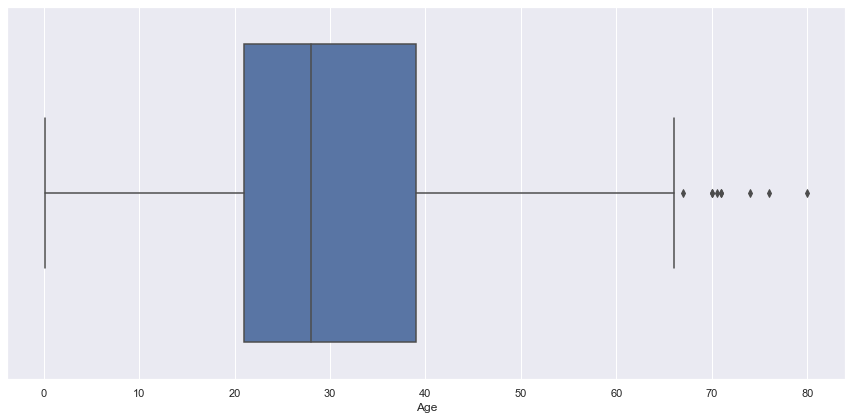

In [13]:
fig, ax = subplots( figsize=(12,6) )

sns.boxplot( x=df1['Age'], ax=ax )

plt.tight_layout()

In [14]:
print('Median:', int( df1['Age'].median() ) )

Median: 28


In [15]:
df1['Age'].fillna( df1['Age'].median(), inplace=True )

## 1.6. Descriptive Statistical

For this step we will separate the numeric and categorical variables.

In [16]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1[['Sex', 'Embarked']]

### 1.6.1. Numerical Attributes

For the numerical variables we use two types of analysis.

- Central tendency
    - average
    - median
    
- Dispersion
    - count
    - std - standard deviation
    - min
    - max
    - first quartile
    - third quartile

In [17]:
num_attributes.describe()

,Passenger_id,Survived,Ticket_class,Age,Acc_siblings_or_spouses,Acc_parents_or_children,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.503186,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,12.905241,1.041658,0.865560,51.738879
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### 1.6.2. Categorical Attributes

For categorical variables we will use the countplot, which show the counts of observations in each categorical bin using bars.

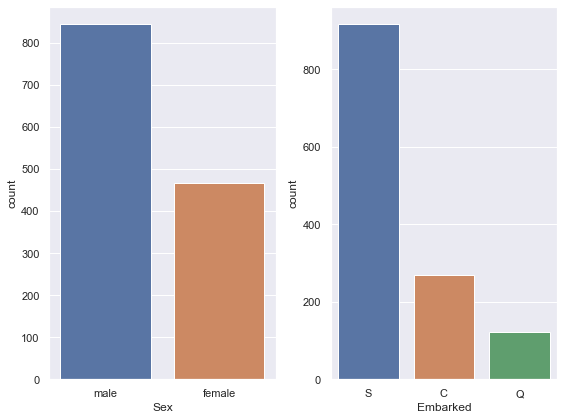

In [18]:
fig, ax = subplots( nrows=1, ncols=2, figsize=(8, 6) )
sns.countplot( x = cat_attributes['Sex'], ax=ax[0] )

sns.countplot( x = cat_attributes['Embarked'], ax=ax[1] )

plt.tight_layout()

# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

In this step, we created a mind map hypothesis, in order to visualize all the variables we have and create relevant hypotheses for this context. Next, we'll create features that will be important for exploratory data analysis.

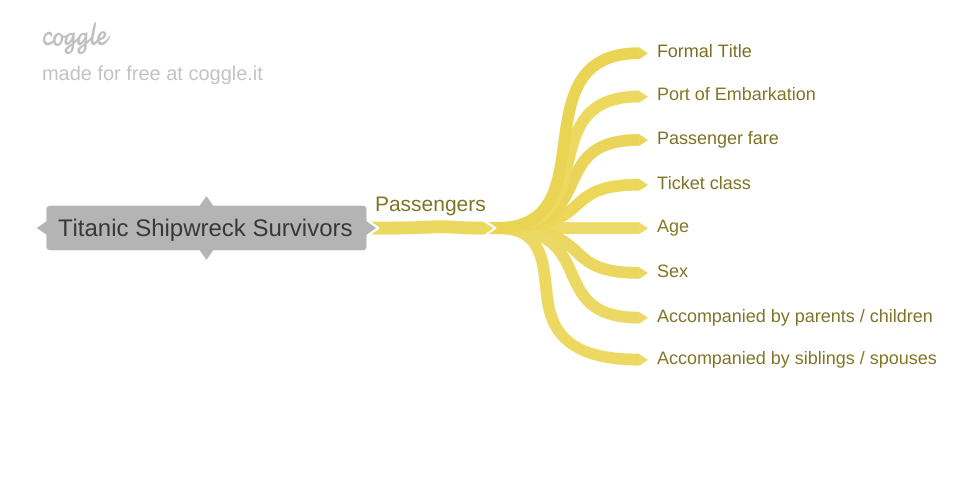

In [20]:
Image('img/Titanic_Shipwreck_Survivors.png')

## 2.1. Creation of Hypothesis

**1.** Passengers accompanied by parents or children survive, on average, less than unaccompanied passengers

**2.** Passengers accompanied by siblings or spouses survive, on average, less than unaccompanied passengers

**3.** Passengers with the formal title of master, on average, survived more than passengers with the formal title of Mr

**4.** Passengers who boarded the port of southampton, on average, survived more than passengers who boarded at other port

**5.** Children and the elderly survived, on average, more than adults

**6.** In total, there were more female survivors than male survivors.

**7.** In total, there were more 1st class passenger survivors than the other classes

**8.** Passengers who paid more expensive fares survived more than passengers who paid less

## 2.2. Feature Engineering

To validate our hypotheses we need to create just one more feature: formal title.

In [21]:
df2['Formal_title'] = 'na'
df2['Formal_title'] = df2['Name'].apply( lambda x: 'Miss' if 'Miss' in x else
                                                 'Mrs' if 'Mrs' in x else 
                                                 'Master' if 'Master' in x else 
                                                 'Col' if 'Col' in x else 
                                                 'Major' if 'Major' in x else 'Mr' )

# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,Passenger_id,Survived,Ticket_class,Name,Sex,Age,Acc_siblings_or_spouses,Acc_parents_or_children,Ticket,Fare,Embarked,Formal_title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


In this step we will ensure that we only use the relevant information to resolve the issue. For this we will separate this step into two:

**1.** Filtering Rows

**2.** Filtering Columns

## 3.1. Filtering Rows

Previously, we merged the training and testing datasets to perform data cleaning and preparation. However, as the test data does not have the variable "survived", we will remove it from this dataframe. Test data will be used in later steps.

In [24]:
# filtering the rows
df3_test = df3[df3['Survived'].isna()]
df3 = df3[df3['Survived'].notna()]

## 3.2. Filtering Columns

Now, we are going to remove the columns that will not be needed for the next steps and for training the model.

**1.** Passenger_id - This variable will not be relevant in this case.

**2.** Name - This variable has already been used to create the formal title feature, however it will no longer be needed.

**3.** Ticket - This variable will not be relevant in this case.

In [25]:
df3.drop( columns=['Passenger_id', 'Name', 'Ticket'], axis=1, inplace=True )
df3_test.drop( columns=['Passenger_id', 'Name', 'Ticket'], axis=1, inplace=True )

# 4.0. Exploratory Data Analysis

In this step, we will perform an exploratory data analysis to better understand the data and gain insights. We'll do 3 types of analysis:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

In [26]:
df4 = df3.copy()
df4_test = df3_test.copy()

## 4.1. Univariate Analysis

Univariate analysis is the most basic form of statistical data analysis technique. When the data contains only one variable and doesn’t deal with a causes or effect relationships then a Univariate analysis technique is used.

### 4.1.1. Response Variable

We build a countplot to see the number of observations for each class. In this case, how many passengers survived and how many died. As we can see, a little more than three hundred passengers survived and more than five hundred died.

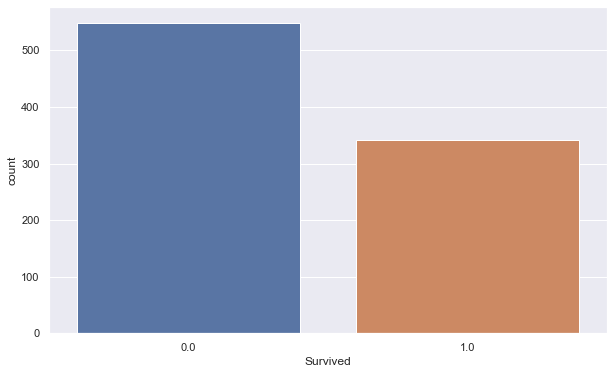

In [27]:
fig, ax = subplots( figsize = (10, 6) )

sns.countplot( x = df4['Survived'] );

plt.show()

### 4.1.2. Numerical Variable

For the numeric variables, we draw a histogram to visualize the distribution of each feature.

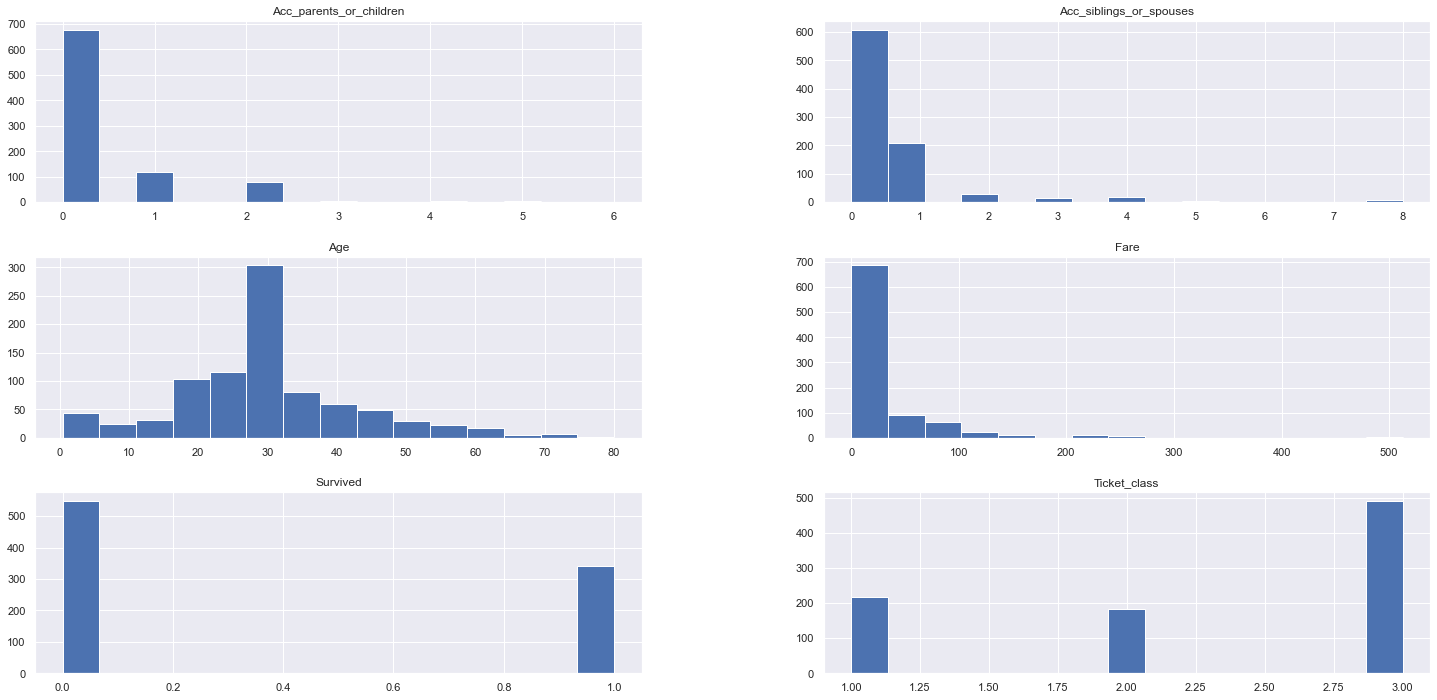

In [28]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=15 );

From the graphs above, we can get some conclusions:

- **Age**: Most passengers were in their 30s.
- **Ticket_class**: Most passengers were in 3rd class.

### 4.1.3. Categorical Variable

In [29]:
df4.select_dtypes( include=['object'] ).columns

Index(['Sex', 'Embarked', 'Formal_title'], dtype='object')

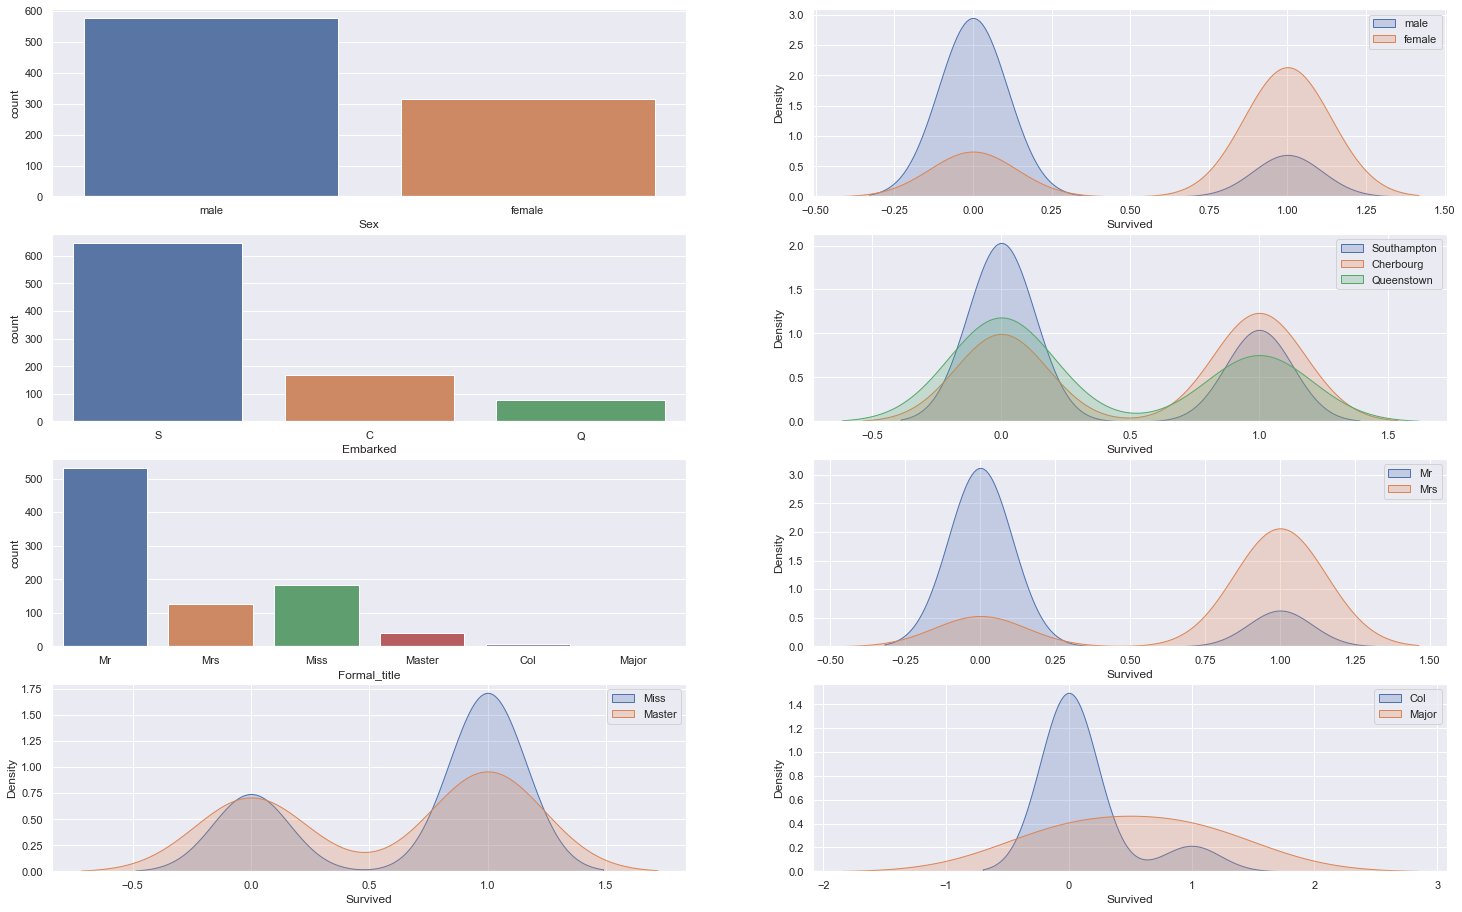

In [30]:
plt.figure( figsize=(25, 20))

# Sex
plt.subplot(5, 2, 1)
sns.countplot( x=df4['Sex'] )

plt.subplot(5, 2, 2)
sns.kdeplot(df4[df4['Sex'] == 'male']['Survived'], label  = 'male', shade = True)
sns.kdeplot(df4[df4['Sex'] == 'female']['Survived'], label = 'female', shade = True)
plt.legend()

# Embarked
plt.subplot(5, 2, 3)
sns.countplot( x=df4['Embarked'] )

plt.subplot(5, 2, 4)
sns.kdeplot(df4[df4['Embarked'] == 'S']['Survived'], label = 'Southampton', shade = True)
sns.kdeplot(df4[df4['Embarked'] == 'C']['Survived'], label  = 'Cherbourg', shade = True)
sns.kdeplot(df4[df4['Embarked'] == 'Q']['Survived'], label = 'Queenstown', shade = True)
plt.legend()

# Embarked
plt.subplot(5, 2, 5)
sns.countplot( x=df4['Formal_title'] )

plt.subplot(5, 2, 6)
sns.kdeplot(df4[df4['Formal_title'] == 'Mr']['Survived'], label  = 'Mr', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Mrs']['Survived'], label = 'Mrs', shade = True)
plt.legend()

plt.subplot(5, 2, 7)
sns.kdeplot(df4[df4['Formal_title'] == 'Miss']['Survived'], label = 'Miss', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Master']['Survived'], label = 'Master', shade = True)
plt.legend()

plt.subplot(5, 2, 8)
sns.kdeplot(df4[df4['Formal_title'] == 'Col']['Survived'], label = 'Col', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Major']['Survived'], label = 'Major', shade = True)
plt.legend()

plt.show()

From the graphs above, we can get some conclusions:

- **Sex**: Most women survived and most men died.
- **Embarked**: Most passengers who boarded the port of southampton didn't survive
- **Formal_title**: The formal title didn't influence the target variable

## 4.2. Bivariate Analysis

**1.** Passengers accompanied by parents or children survive, on average, less than unaccompanied passengers

**2.** Passengers accompanied by siblings or spouses survive, on average, less than unaccompanied passengers

**3.** Passengers with the formal title of master, on average, survived more than passengers with the formal title of Mr

**4.** Passengers who boarded the port of southampton, on average, survived more than passengers who boarded at other port

**5.** Children and the elderly survived, on average, more than adults

**6.** In total, there were more female survivors than male survivors.

**7.** In total, there were more 1st class passenger survivors than the other classes

**8.** Passengers who paid more expensive fares survived more than passengers who paid less

### H1. Passengers accompanied by parents or children survive, on average, less than unaccompanied passengers

**False!** Passengers accompanied by parents or children survive, on average, more than unaccompanied passengers.

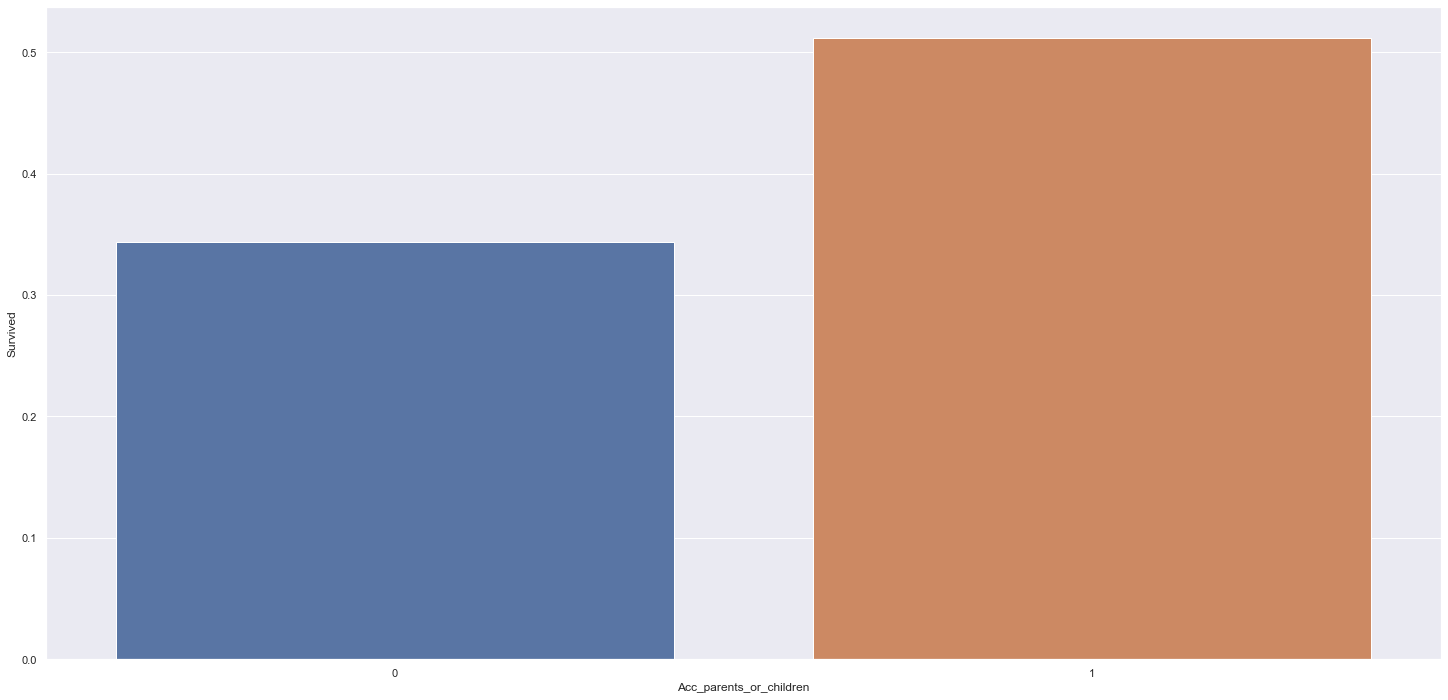

In [31]:
aux01 = df4[['Survived']].copy()
aux01['Acc_parents_or_children'] = df4['Acc_parents_or_children'].apply( lambda x: 1 if x != 0 else 0 )
aux02 = aux01.groupby( 'Acc_parents_or_children' ).mean().reset_index()

fig, ax = plt.subplots()
sns.barplot( x = 'Acc_parents_or_children', y = 'Survived', data=aux02 )

### **H2. Passengers accompanied by siblings or spouses survive, on average, less than unaccompanied passengers**

**False!** Passengers accompanied by siblings or spouses survive, on average, more than unaccompanied passengers.

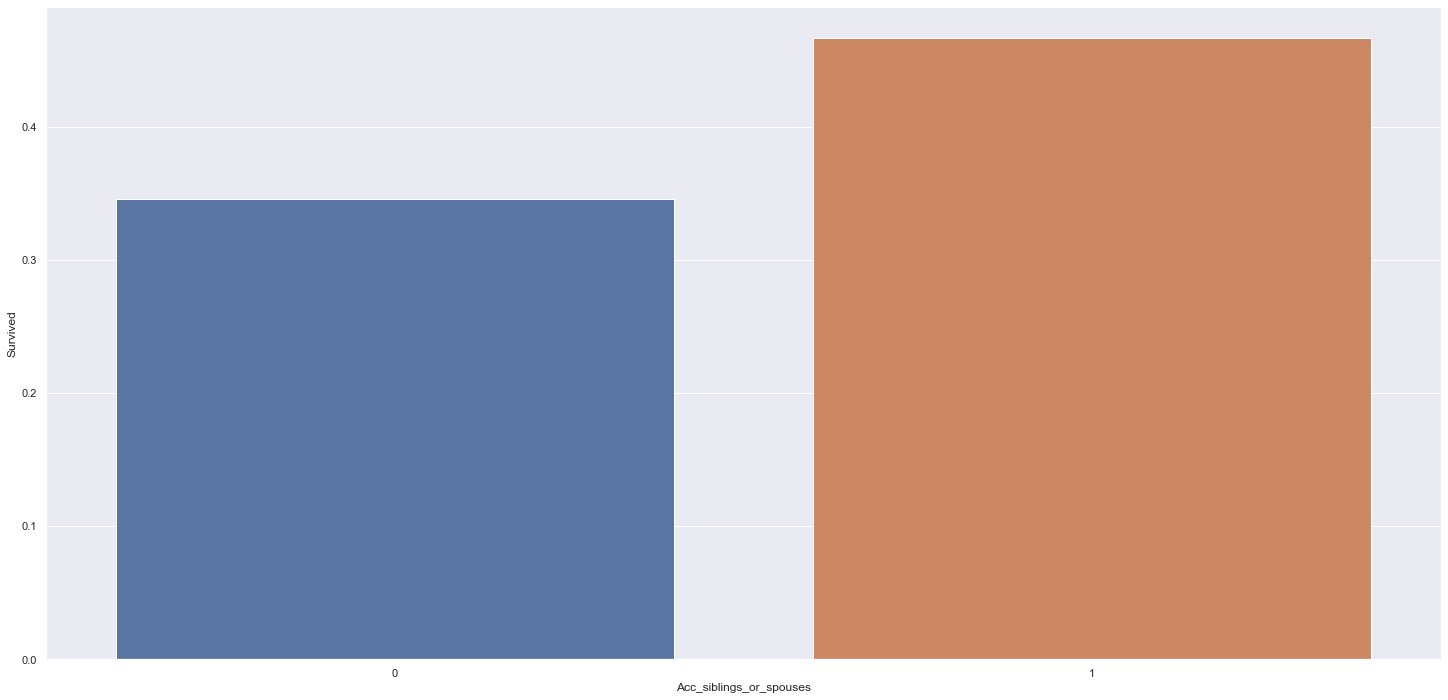

In [32]:
aux01 = df4[['Survived']].copy()
aux01['Acc_siblings_or_spouses'] = df4['Acc_siblings_or_spouses'].apply( lambda x: 1 if x != 0 else 0 )
aux02 = aux01.groupby( 'Acc_siblings_or_spouses' ).mean().reset_index()

fig, ax = plt.subplots()
sns.barplot( x = 'Acc_siblings_or_spouses', y = 'Survived', data=aux02 )

### **H3. Passengers with the formal title of Master, on average, survived more than passengers with the formal title of Mr**

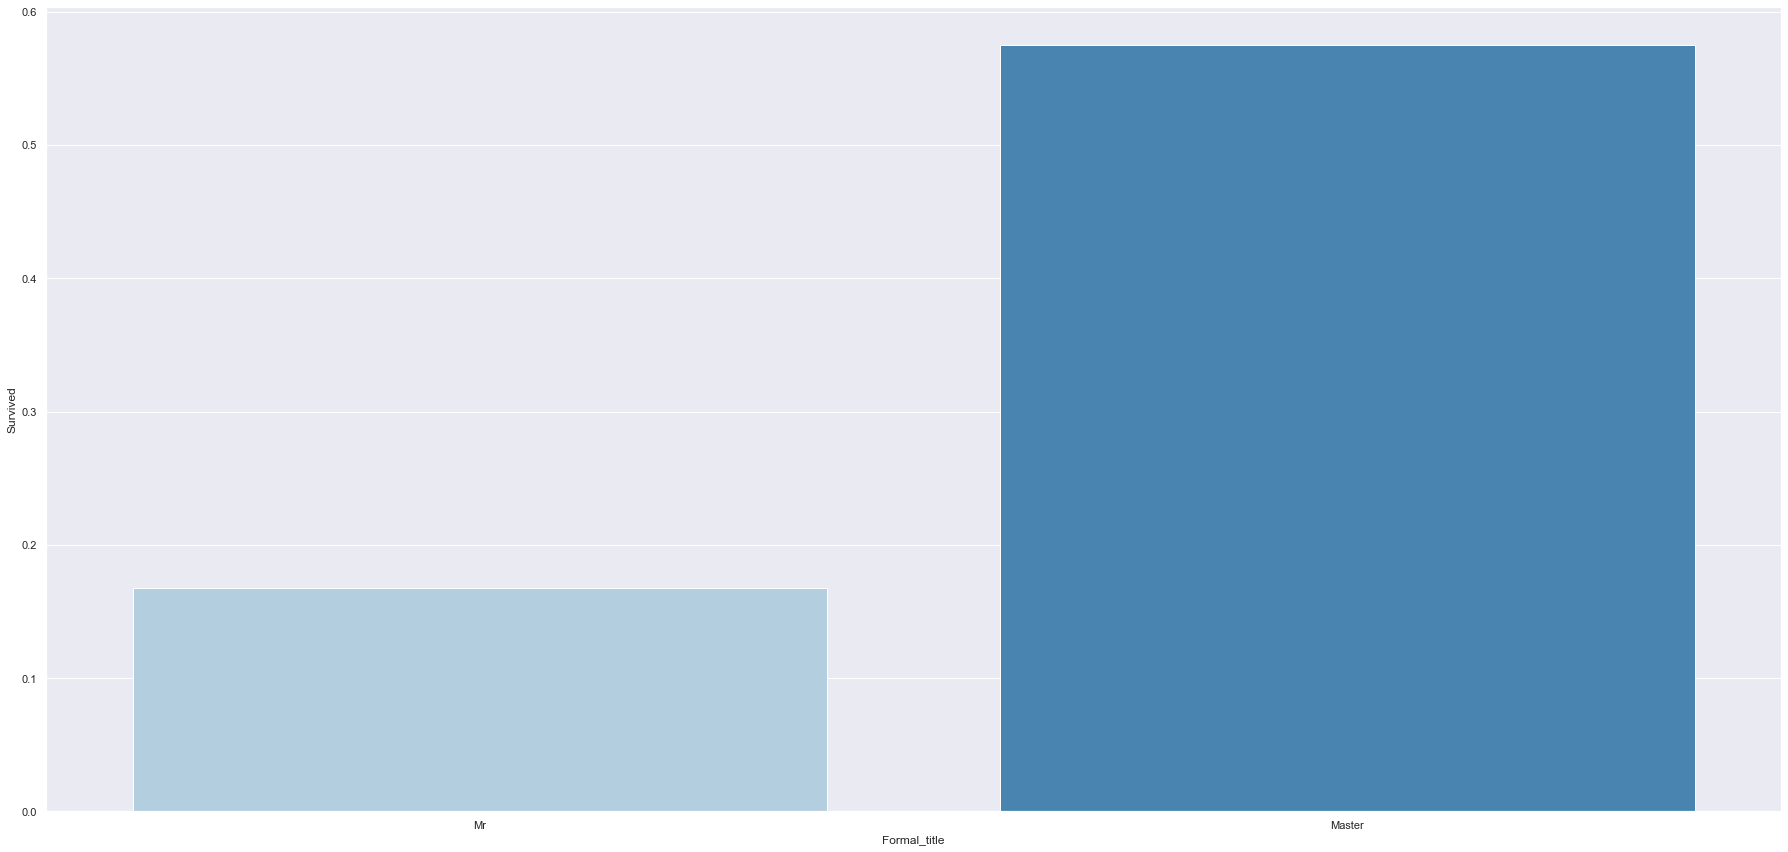

In [33]:
aux01 = df4.loc[(df4['Formal_title'] == 'Mr') | (df4['Formal_title'] == 'Master'), ['Survived', 'Formal_title']]
aux02 = aux01.groupby('Formal_title').mean().reset_index()

fig, ax = subplots()
sns.barplot( x='Formal_title', y='Survived', data=aux02, palette='Blues', order=['Mr', 'Master'] )

plt.tight_layout()

### H4. Passengers who boarded the port of southampton, on average, survived more than passengers who boarded at other port

**False!** Passengers who boarded the port of southampton, on average, survived less than passengers who boarded at other port.

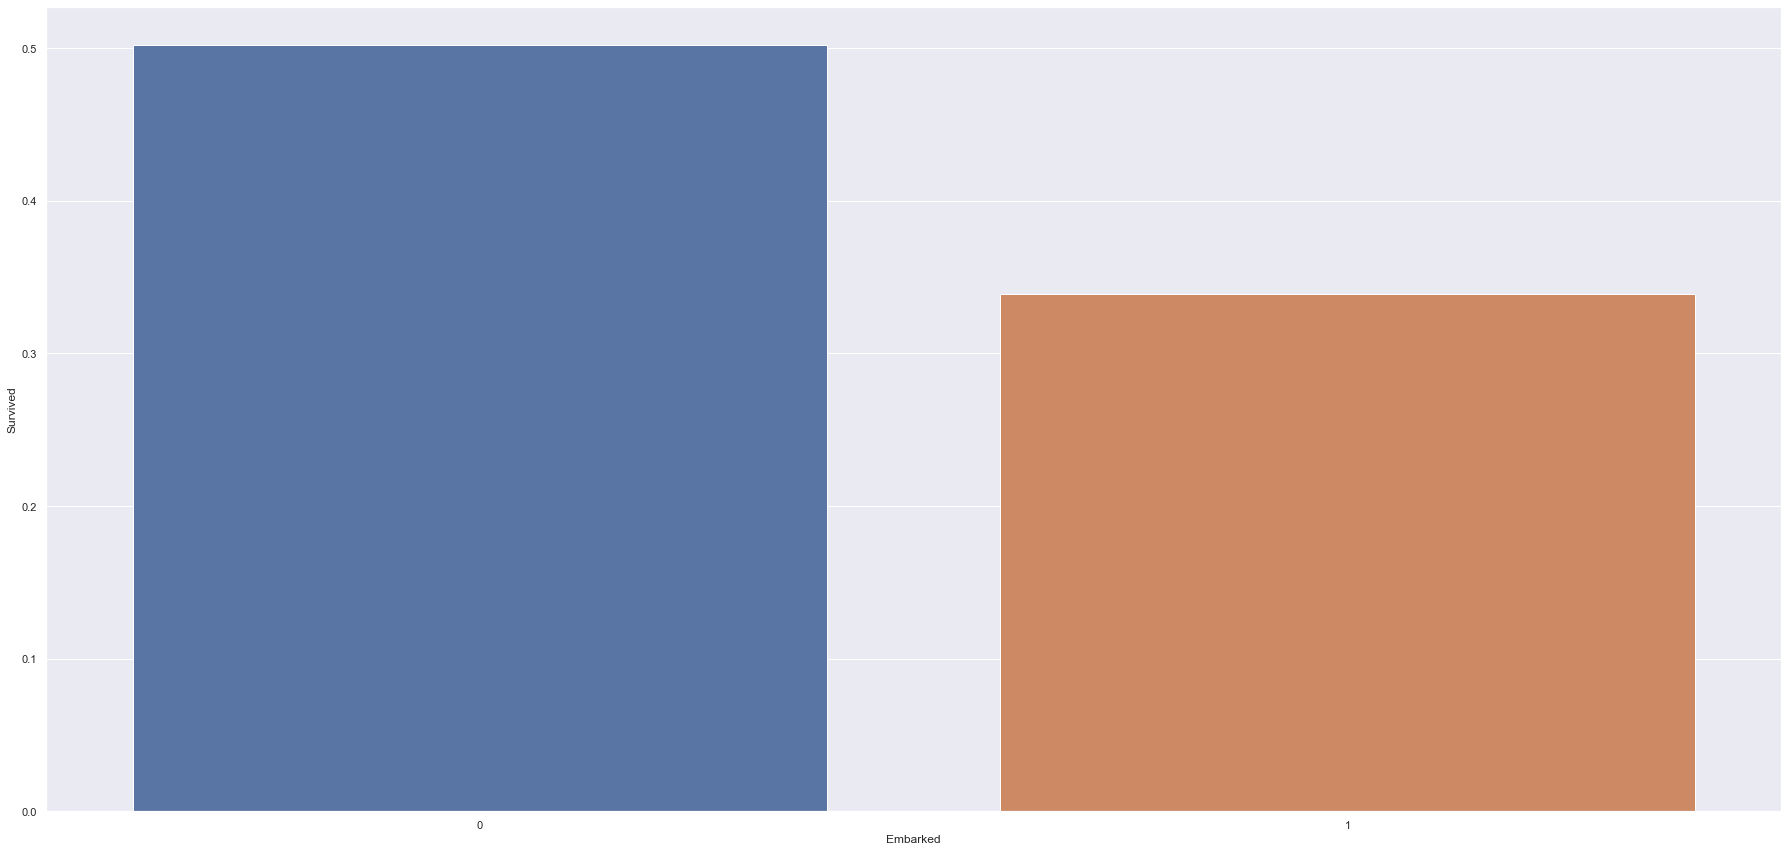

In [34]:
aux01 = df4[['Survived', 'Embarked']].copy()
aux01['Embarked'] = aux01['Embarked'].map( {'S': 1, 'C': 0, 'Q': 0} )
aux02 = aux01.groupby( 'Embarked' ).mean().reset_index()

fig, ax = plt.subplots()
sns.barplot( x = 'Embarked', y = 'Survived', data = aux02 )

plt.tight_layout()

### H5. Children and the elderly survived, on average, more than adults

**True!**

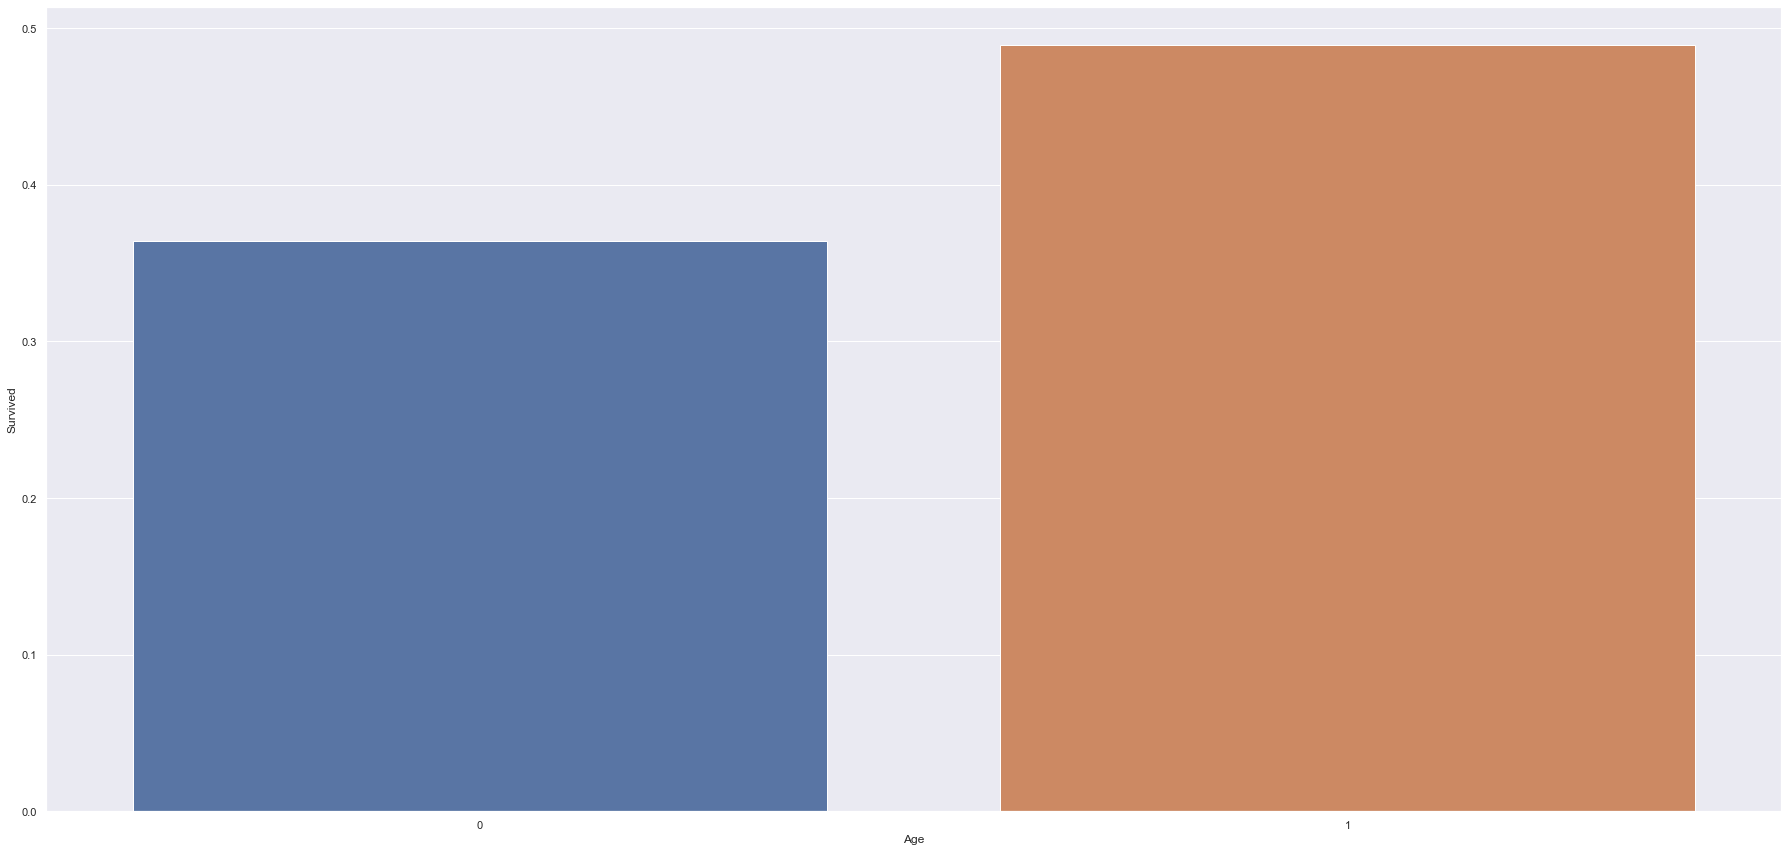

In [35]:
aux01 = df4[['Age', 'Survived']].copy()
aux01['Age'] = aux01['Age'].apply( lambda x: 1 if x <= 17 or x >= 60 else 0 )
aux02 = aux01.groupby( 'Age' ).mean().reset_index()

fig, ax = subplots()
sns.barplot( x = 'Age', y = 'Survived', data = aux02 )

plt.tight_layout()

### H6. In total, there were more female survivors than male survivors.

**True!**

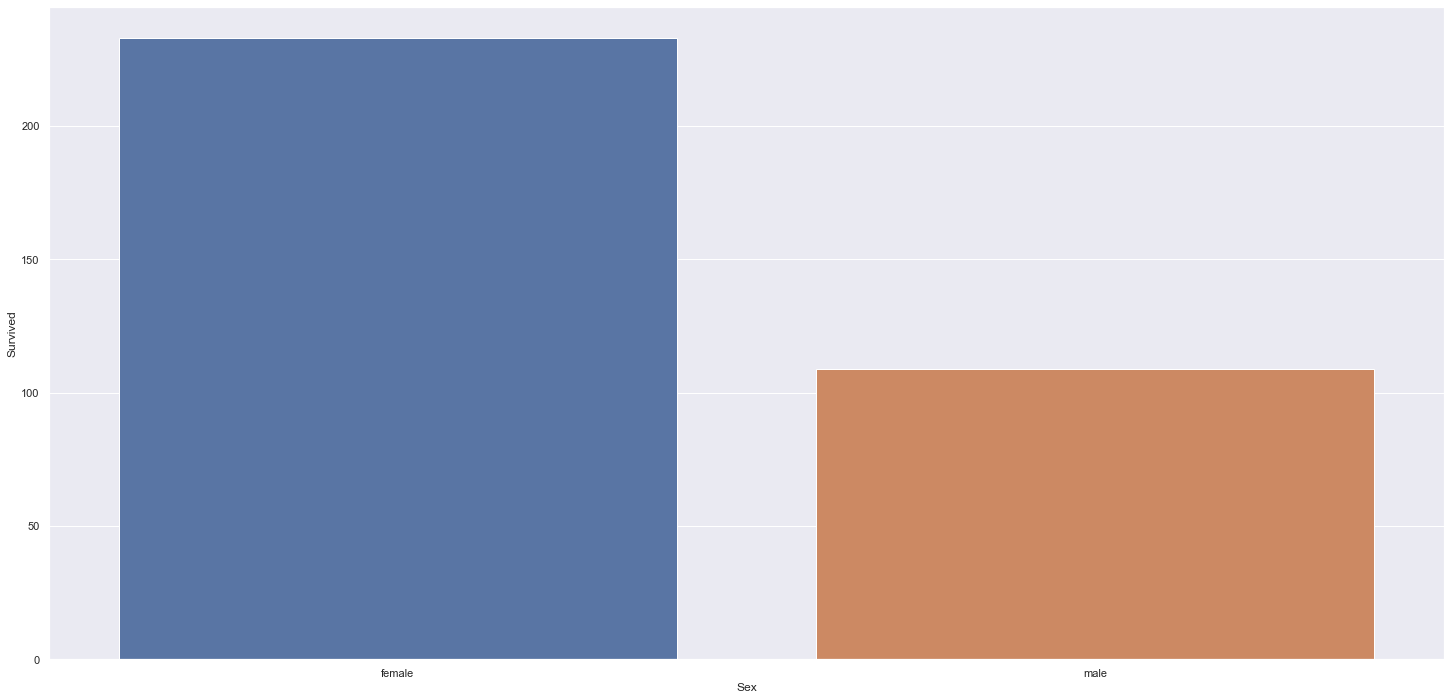

In [36]:
aux01 = df4[['Sex', 'Survived']].groupby('Sex').sum().reset_index()

fig, ax = plt.subplots()
sns.barplot( x = 'Sex', y = 'Survived', data = aux01 )

### H7. On average, there were more 1st class passenger survivors than the other classes

**True!**

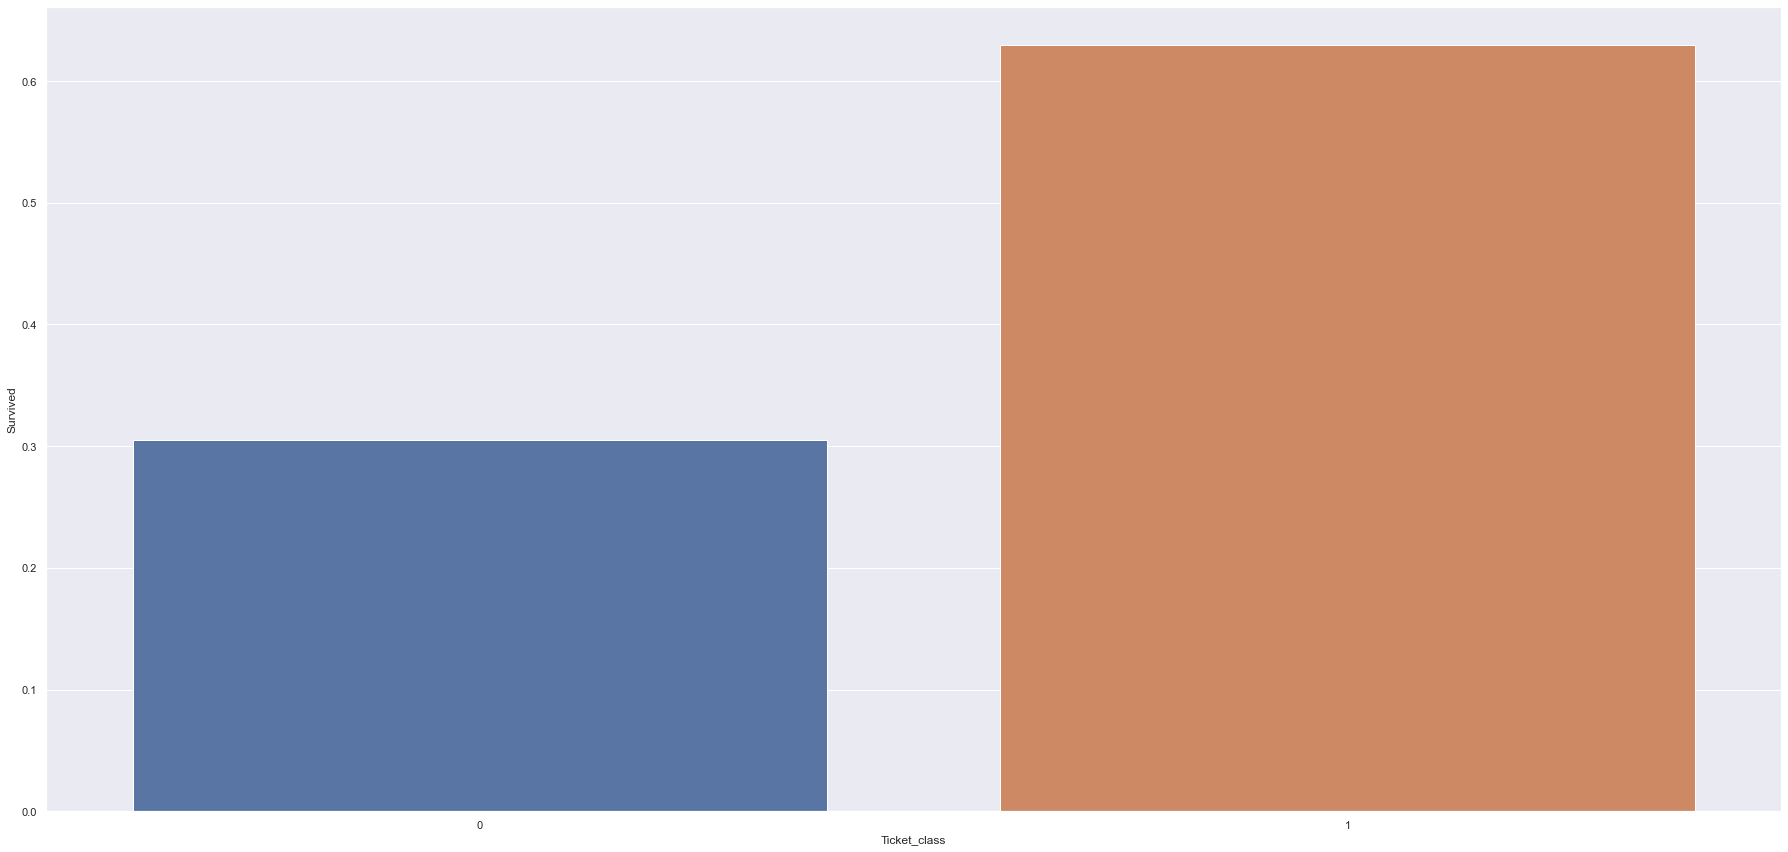

In [37]:
aux01 = df4[['Survived', 'Ticket_class']].copy()
aux01['Ticket_class'] = aux01['Ticket_class'].apply( lambda x: 0 if x != 1 else 1 )
aux02 = aux01.groupby('Ticket_class').mean().reset_index()

fig, ax = subplots()
sns.barplot( x = 'Ticket_class', y = 'Survived', data = aux02 )

plt.tight_layout()

### H8. Passengers who paid more expensive fares, on average, survived more than passengers who paid less

**False!** Its not true for all cases.


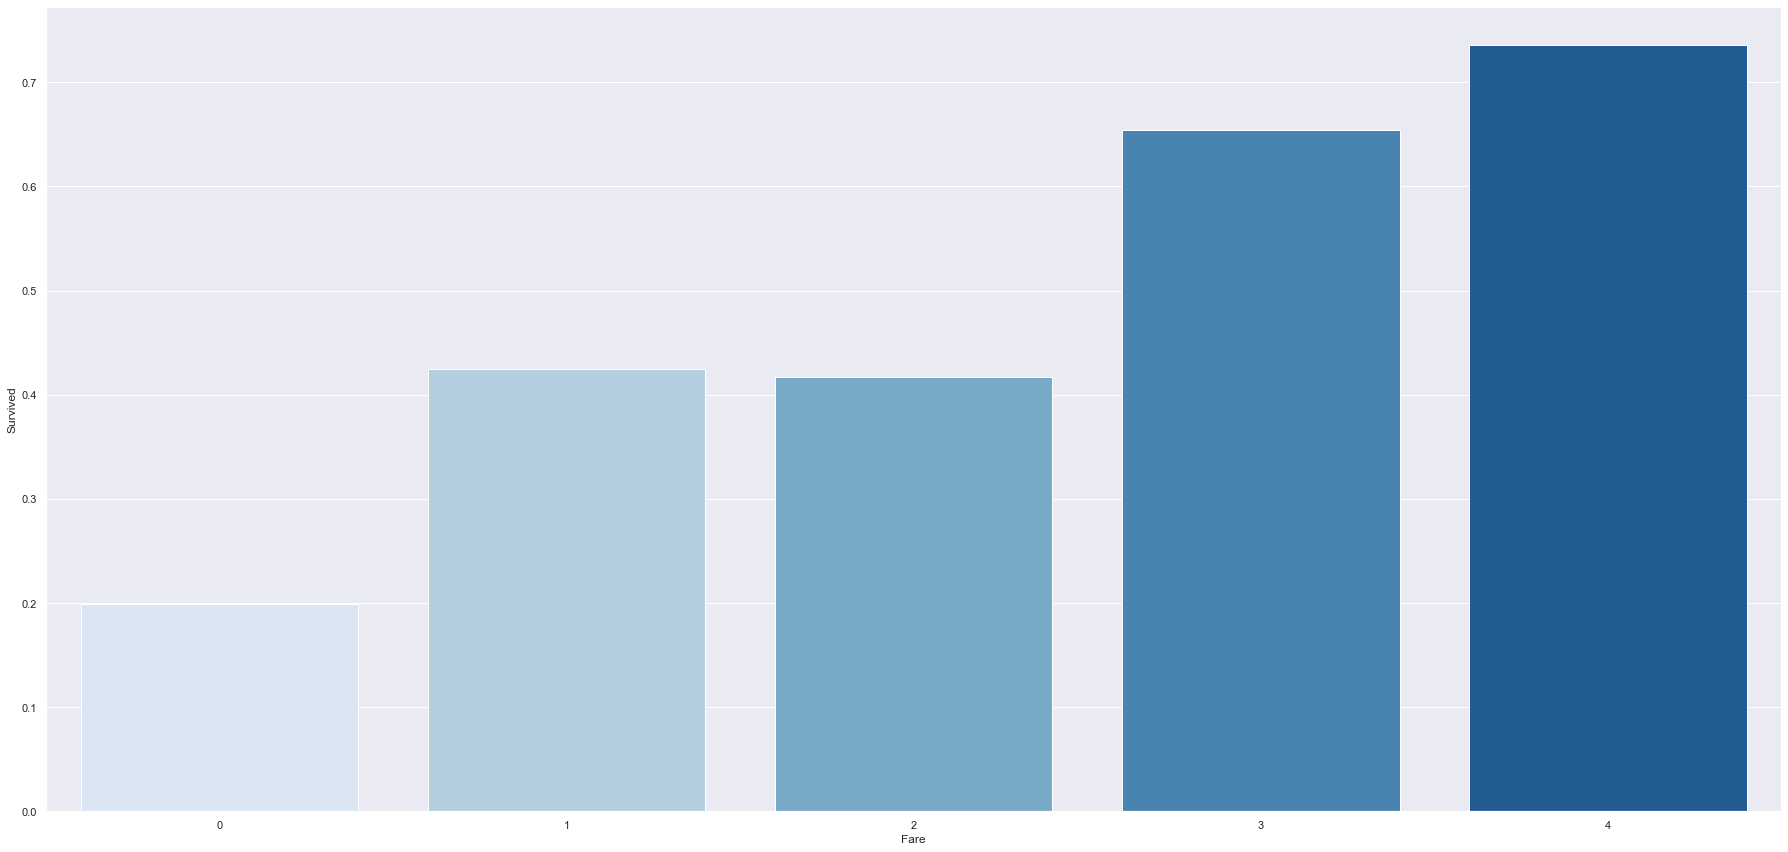

In [38]:
aux01 = df4[['Fare', 'Survived']].copy()
aux01['Fare'] = aux01['Fare'].apply( lambda x: 0 if x <= 10 else 1 if x <= 20 else 2 if x <= 50 else 3 if x <= 100 else 4 )
aux02 = aux01.groupby( 'Fare' ).mean().reset_index()

fig, ax = plt.subplots()
sns.barplot( x = 'Fare', y = 'Survived', data = aux02, palette = 'Blues' )

plt.tight_layout()

## 4.3. Multivariate Analysis

Multivariate analysis (MVA) is a Statistical procedure for analysis of data involving more than one type of measurement or observation. It may also mean solving problems where more than one dependent variable is analyzed simultaneously with other variables.

This step will be divided into two:
- Numerical Attributes
- Categorical attributes

### 4.3.1 Numerical Attributes

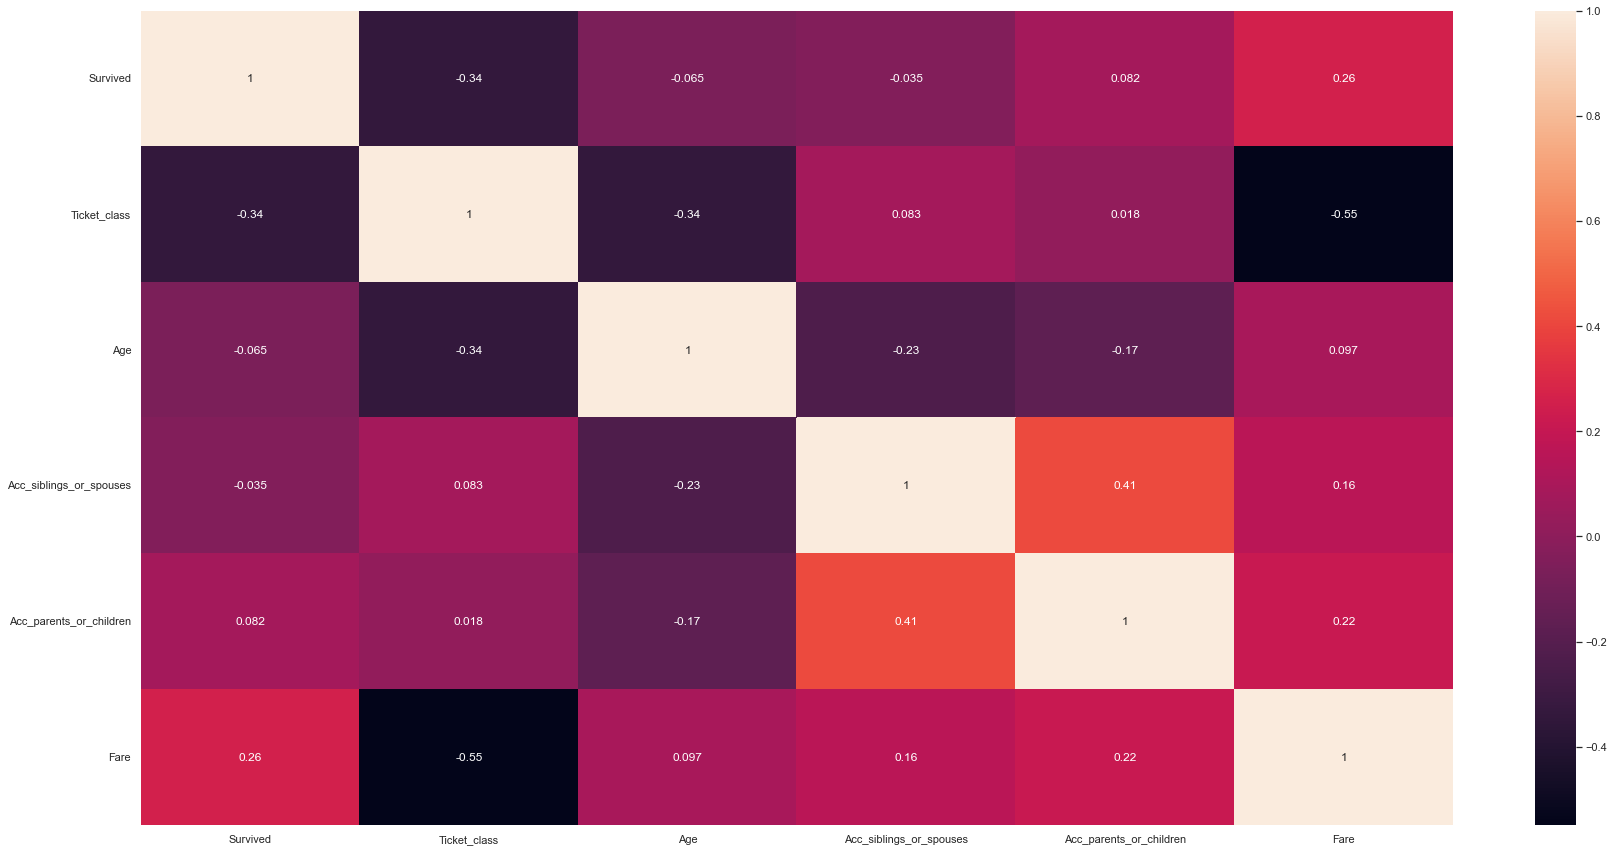

In [39]:
# heat map
correlation = num_attributes.corr()

fig, ax = subplots()
sns.heatmap( correlation, annot = True )

plt.tight_layout()

We will look at the columns that have the lightest and darkest data, note the following columns:

There are no variables that have some dependence on the response variable.

### 4.3.2. Categorical Attributes

To do the multivariate analysis we will use the association measure [Cramers'V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V). It consists of measuring the association between two variables, giving a value between 0 and +1, based on chi-squared statistic.

**The construction of the function "cramer_v" was developed in the "Helper Functions" section.**

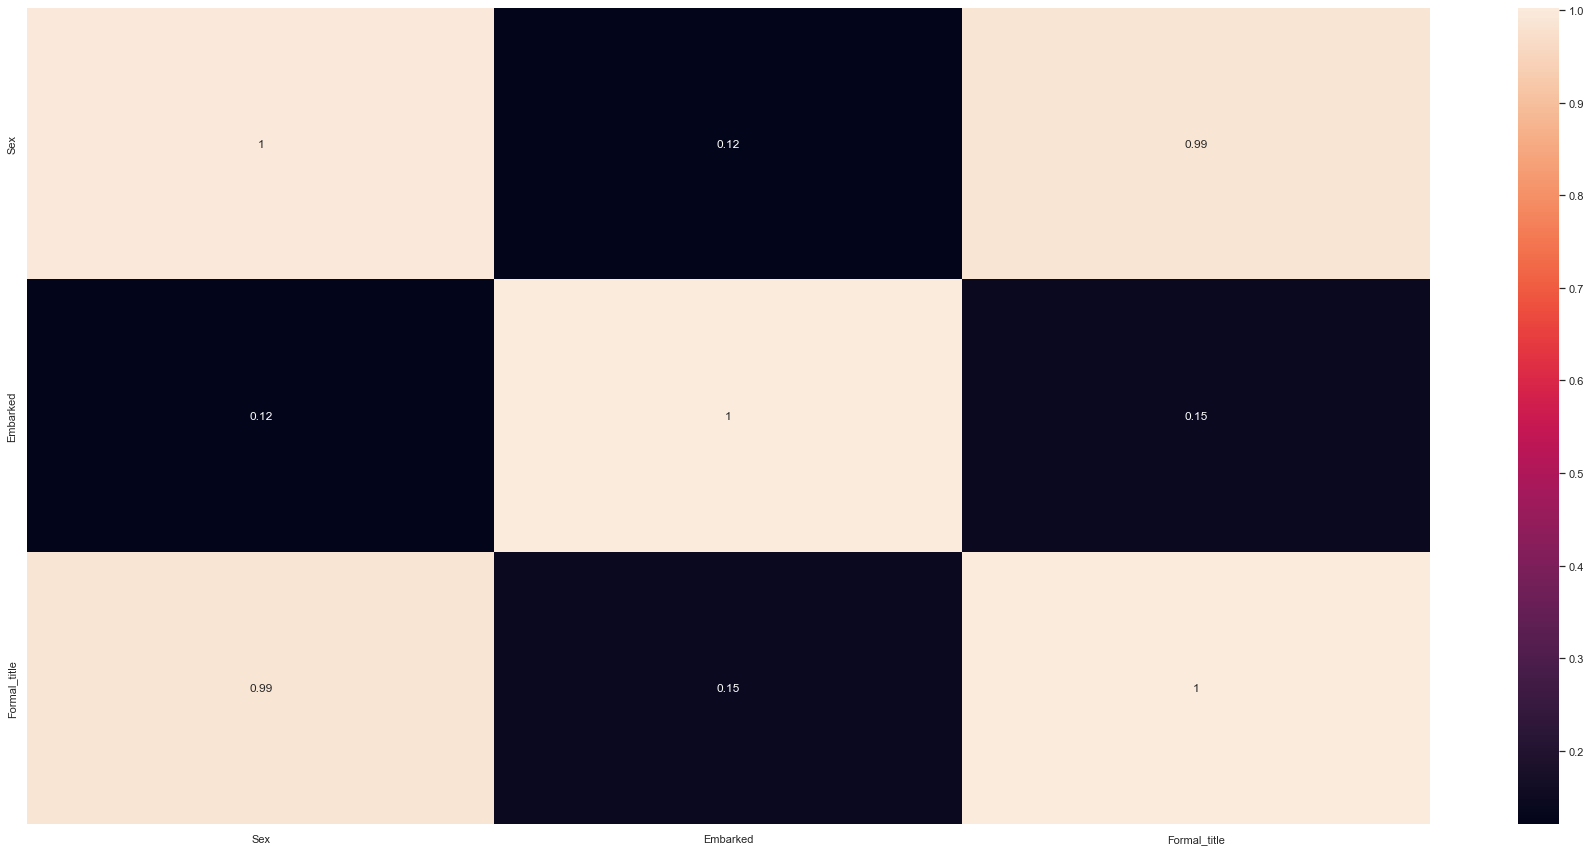

In [41]:
# only categorical data
a = df4.select_dtypes( include = 'object' )

# dataframe with cramer v calculations
df = cramer_v(a)
df = df.set_index(df.columns)

# plot heatmap
fig, ax = plt.subplots()
sns.heatmap( df, annot = True )

plt.tight_layout()

According to the heat map, we found that there is a high correlation between the variables Sex and Formal Title. This isn't a surprise, as the formal title is based on passenger's gender.

# 5.0. Data Preparation

In this step, we'll prepare data (Normalization and Encoding) to be used in the predictive model without harming its performance.

In [99]:
df5 = df4.copy()
df5_test = df4_test.copy()

## 5.1. Rescaling

In [43]:
df5.select_dtypes( include=['int64', 'float64'] ).columns

Index(['Survived', 'Ticket_class', 'Age', 'Acc_siblings_or_spouses',
       'Acc_parents_or_children', 'Fare'],
      dtype='object')

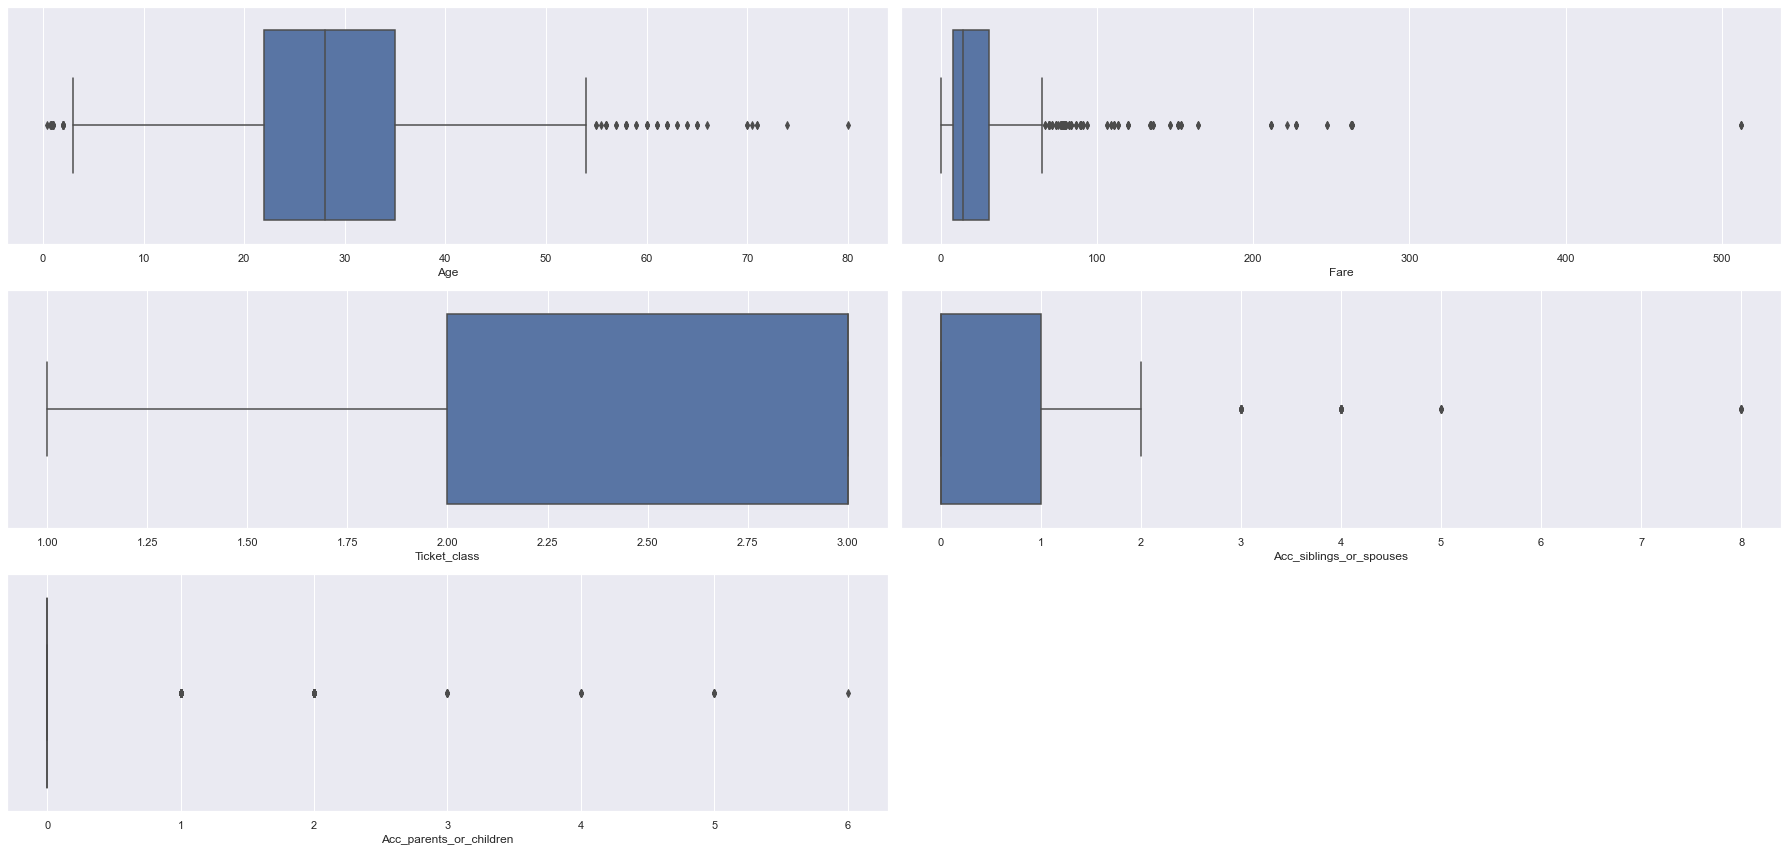

In [45]:
plt.subplot(3, 2, 1)
sns.boxplot( x = df5['Age'] )

plt.subplot(3, 2, 2)
sns.boxplot( x = df5['Fare'] )

plt.subplot(3, 2, 3)
sns.boxplot( x = df5['Ticket_class'] )

plt.subplot(3, 2, 4)
sns.boxplot( x = df5['Acc_siblings_or_spouses'] )

plt.subplot(3, 2, 5)
sns.boxplot( x = df5['Acc_parents_or_children'] )

plt.tight_layout()

- Age - There are many outliers, so we will use RobustScaler.
- Fare - There are many outliers, so we will use RobustScaler.
- Ticket_class - There are no outliers, so we will use MinMaxScaler.
- Acc_siblings_or_spouses - There are few outliers, so we will use MinMaxScaler.
- Acc_parents_or_children - There are few outliers, so we will use MinMaxScaler.

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()

# Age - RobustScaler
df5['Age'] = rs.fit_transform( df5[['Age']].values )
df5_test['Age'] = rs.fit_transform( df5_test[['Age']].values )

# Fare - RobustScaler
df5['Fare'] = rs.fit_transform( df5[['Fare']].values )
df5_test['Fare'] = rs.fit_transform( df5_test[['Fare']].values )

# Ticket_class - MinMaxScaler
df5['Ticket_class'] = mms.fit_transform( df5[['Ticket_class']].values )
df5_test['Ticket_class'] = mms.fit_transform( df5_test[['Ticket_class']].values )

# Acc_siblings_or_spouses - MinMaxScaler
df5['Acc_siblings_or_spouses'] = mms.fit_transform( df5[['Acc_siblings_or_spouses']].values )
df5_test['Acc_siblings_or_spouses'] = mms.fit_transform( df5_test[['Acc_siblings_or_spouses']].values )

# Acc_parents_or_children - MinMaxScaler
df5['Acc_parents_or_children'] = mms.fit_transform( df5[['Acc_parents_or_children']].values )
df5_test['Acc_parents_or_children'] = mms.fit_transform( df5_test[['Acc_parents_or_children']].values )

## 5.2. Encoding

In [47]:
df5.select_dtypes( include = ['object'] ).columns

Index(['Sex', 'Embarked', 'Formal_title'], dtype='object')

In [101]:
le = LabelEncoder()

# Sex
df5['Sex'] = le.fit_transform( df5['Sex'] )
df5_test['Sex'] = le.fit_transform( df5_test['Sex'] )

# Embarked
df5['Embarked'] = le.fit_transform( df5['Embarked'] )
df5_test['Embarked'] = le.fit_transform( df5_test['Embarked'] )

# 6.0. Feature Selection

In this step, we'll only select the features that will be important to the forecasting model to ensure that the data doesn't compromise its accuracy.

In [102]:
df6 = df5.copy()
df6_test = df5_test.copy()

In the exploratory data analysis step, we saw that the formal title variable is highly correlated with the passenger's sex. Although it was useful to validate one of our hypotheses, it will be deleted.

In [103]:
df6 = df6.drop( 'Formal_title', axis=1 )
df6_test = df6_test.drop( 'Formal_title', axis=1 )

## 6.1. Split dataframe into training and test

In [104]:
# Predict variables
X = df6.drop( 'Survived', axis=1 )

# Target variable
y = df6['Survived']

# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state = 13 )

# 7.0. Machine Learning Modeling

In this step, we'll build our predictive models. Therefore, we will use 5 machine learning algorithms, which will be:

- Random Forest Classifier
- Logistic Regression
- Naive Bayes
- K-Nearest Neighbors Classifier

We will also use the cross-validation technique to estimate the machine learning model's ability on unseen data.

## 7.1. Random Forest Classifier

In [52]:
# model
rf = RandomForestClassifier( n_jobs = -1 )

# fit model
rf.fit( X_train, y_train )

# predict model
yhat_rf = rf.predict( X_test )

# metrics
rf_result = ml_metrics( y_test, yhat_rf )
rf_result

,Accuracy,Precision,Recall,F1
0,0.810056,0.739726,0.782609,0.760563


### 7.1.1. Random Forest Classifier - Cross Validation

In [53]:
# model
rf = RandomForestClassifier( n_jobs = -1 )

# cross validation
rf_cv_result = cross_validation( rf, X_train, y_train )
rf_cv_result

,Accuracy CV,Precision CV,Recall CV,F1 CV
0,0.78 +/- 0.02,0.74 +/- 0.06,0.68 +/- 0.06,0.71 +/- 0.04


## 7.2. Logistic Regression

In [54]:
# model
lr = LogisticRegression( random_state = 13 )

# fit model
lr.fit( X_train, y_train )

# predict
yhat_lr = lr.predict( X_test )

# metrics
lr_result = ml_metrics( y_test, yhat_lr )
lr_result

,Accuracy,Precision,Recall,F1
0,0.832402,0.791045,0.768116,0.779412


### 7.2.1. Logistic Regression - Cross Validation

In [55]:
# model
lr = LogisticRegression( random_state = 13 )

# cross validation
lr_cv_result = cross_validation( lr, X_train, y_train )
lr_cv_result

,Accuracy CV,Precision CV,Recall CV,F1 CV
0,0.78 +/- 0.04,0.74 +/- 0.06,0.68 +/- 0.05,0.71 +/- 0.05


## 7.3. Naive Bayes

In [56]:
# model
nb = GaussianNB()

# fit model
nb.fit( X_train, y_train )

# predict
yhat_nb = nb.predict( X_test )

# metrics
nb_result = ml_metrics( y_test, yhat_nb )
nb_result

,Accuracy,Precision,Recall,F1
0,0.821229,0.746667,0.811594,0.777778


### 7.3.1. Naive Bayes - Cross Validation

In [57]:
# model
nb = GaussianNB()

# cross validation
nb_cv_result = cross_validation( nb, X_train, y_train )
nb_cv_result

,Accuracy CV,Precision CV,Recall CV,F1 CV
0,0.78 +/- 0.03,0.71 +/- 0.04,0.71 +/- 0.06,0.71 +/- 0.04


## 7.4. K-Nearest Neighbors Classifier

In [58]:
# model
knn = KNeighborsClassifier( n_neighbors = 7 )

# fit model
knn.fit( X_train, y_train )

# predict
yhat_knn = knn.predict( X_test )

# metrics
knn_result = ml_metrics( y_test, yhat_knn )
knn_result

,Accuracy,Precision,Recall,F1
0,0.821229,0.784615,0.73913,0.761194


### 7.4.1. K-Nearest Neighbors Classifier - Cross validation

In [59]:
# model
knn = KNeighborsClassifier( n_neighbors = 7 )

# cross validation
knn_cv_result = cross_validation( knn, X_train, y_train )
knn_cv_result

,Accuracy CV,Precision CV,Recall CV,F1 CV
0,0.8 +/- 0.03,0.77 +/- 0.04,0.7 +/- 0.06,0.73 +/- 0.05


## 7.5. Compare Model Performance

### 7.5.1. Single Performance

In [60]:
modelling_result = pd.concat( [rf_result, lr_result, nb_result, knn_result] )
modelling_result.index = ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors']
modelling_result

,Accuracy,Precision,Recall,F1
Random Forest,0.810056,0.739726,0.782609,0.760563
Logistic Regression,0.832402,0.791045,0.768116,0.779412
Naive Bayes,0.821229,0.746667,0.811594,0.777778
K-Nearest Neighbors,0.821229,0.784615,0.739130,0.761194


### 7.5.2. Real Performance

In [61]:
modelling_result_cv = pd.concat( [rf_cv_result, lr_cv_result, nb_cv_result, knn_cv_result] )
modelling_result_cv.index = ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors']
modelling_result_cv

,Accuracy CV,Precision CV,Recall CV,F1 CV
Random Forest,0.78 +/- 0.02,0.74 +/- 0.06,0.68 +/- 0.06,0.71 +/- 0.04
Logistic Regression,0.78 +/- 0.04,0.74 +/- 0.06,0.68 +/- 0.05,0.71 +/- 0.05
Naive Bayes,0.78 +/- 0.03,0.71 +/- 0.04,0.71 +/- 0.06,0.71 +/- 0.04
K-Nearest Neighbors,0.8 +/- 0.03,0.77 +/- 0.04,0.7 +/- 0.06,0.73 +/- 0.05


**As we can see, the KNN model has the best results and will be used in the next steps to predict unseen data.**

# 8.0. Hyperparameter Fine Tuning

Now, let's choose the best hyperparameters for our KNN model. For this, we will use the RandomSearch algorithm.

In [62]:
# define model
knn = KNeighborsClassifier( )

# parameters
parameters = {
    'n_neighbors': list ( range( 1, 30 ) ),
    'leaf_size': list( range( 1, 50 ) ),
    'p': [1, 2]
}

# Define RandomSearchCV
rs = RandomizedSearchCV( knn, parameters, cv=10, n_iter=100, random_state=13, n_jobs=-1 )

# fit RandomSearchCV
rs.fit( X_train, y_train )

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=13)

In [63]:
# The best params to our model
rs.best_estimator_

KNeighborsClassifier(leaf_size=14, n_neighbors=4, p=1)

- From RandomSearch, it can be seen that the best number of leaf_size is 14 while the optimal distance method is Manhattan or p = 1.
- Then the most optimal number of K is 4.

## 8.1. Fit model with the best params - Data test

In [64]:
# model
knn = KNeighborsClassifier( leaf_size=14, n_neighbors=4, p=1 )

# fit model
knn.fit( X_train, y_train )

# predict
yhat_knn = knn.predict( X_test )

# cross validation
knn_result = ml_metrics( y_test, yhat_knn )
knn_result

,Accuracy,Precision,Recall,F1
0,0.804469,0.826923,0.623188,0.710744


## 8.2. Fit model with the best params - Unseen data

In [107]:
# Split variables and target
X = df6_test.drop( 'Survived', axis=1 )

# predict
yhat2_knn = knn.predict( X )

# Predictions
df6_test['Survived'] = yhat2_knn

In [109]:
df6_test.head()

,Survived,Ticket_class,Sex,Age,Acc_siblings_or_spouses,Acc_parents_or_children,Fare,Embarked
891,0.0,1.0,1,0.509804,0.000,0.000000,-0.280670,1
892,0.0,1.0,0,1.490196,0.125,0.000000,-0.315800,2
893,0.0,0.5,1,2.666667,0.000,0.000000,-0.201943,1
894,1.0,1.0,1,-0.078431,0.000,0.000000,-0.245367,2
895,0.0,1.0,0,-0.470588,0.125,0.111111,-0.091793,2


# 9.0. Machine Learning Performance

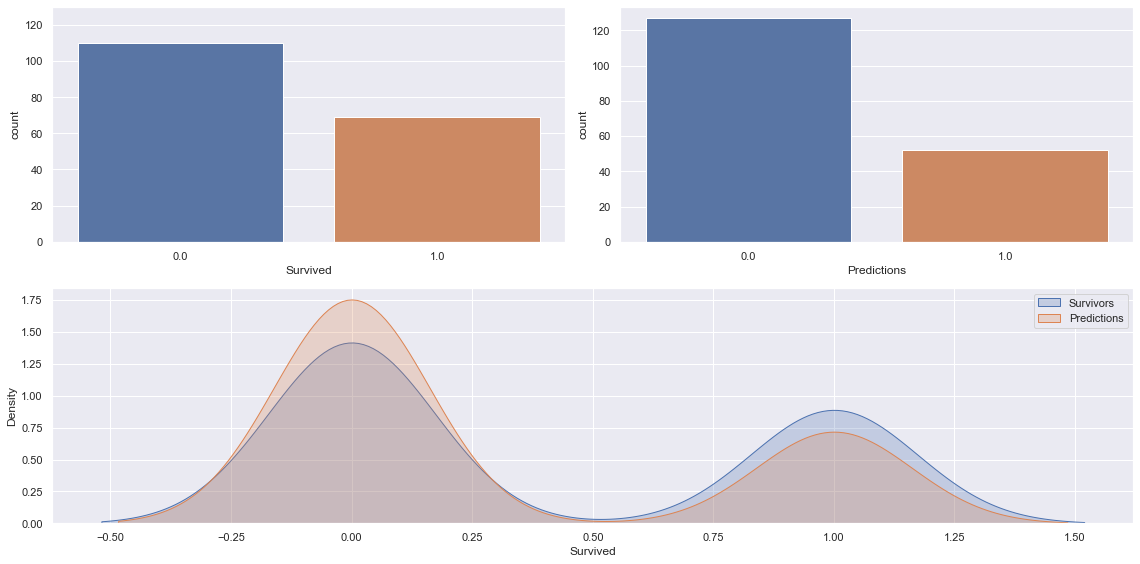

In [167]:
fig = plt.figure( figsize=(16, 8) )
specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )

ax1 = fig.add_subplot( specs[0, 0] )
ax1.set_ylim((0, 130))
ax2 = fig.add_subplot( specs[0, 1] )
ax3 = fig.add_subplot( specs[1, :] )

sns.countplot( x = y_test, ax=ax1 )
sns.countplot( x = yhat_knn, ax=ax2 )
ax2.set_xlabel( 'Predictions' )

sns.kdeplot( y_test, label  = 'Survivors', shade = True, ax=ax3 )
sns.kdeplot( yhat_knn, label = 'Predictions', shade = True, ax=ax3 )
plt.legend()

plt.tight_layout()

**The graphs show that the number of survivors the model predicted is less than the actual number. However, the performance is very good, with a hit rate of approximately 80%.**

# 10.0. Conclusions

Finally, we saw that the model that achieved the best performance was the K-Nearest Neighbors. This project was of great value to apply practices and knowledge that data scientists must have to solve more complex problems.